Found 0 training files and 0 test files

Summary Statistics:
+-----------------------+------------+--------+
| Metric                |   Training |   Test |
+=======================+============+========+
| Number of files       |          0 |      0 |
+-----------------------+------------+--------+
| Number of categories  |          0 |      0 |
+-----------------------+------------+--------+
| Mean file size (KB)   |        nan |    nan |
+-----------------------+------------+--------+
| Median file size (KB) |        nan |    nan |
+-----------------------+------------+--------+
| File size p-value     |        nan |    nan |
+-----------------------+------------+--------+

Category Distribution:
+---------+--------+-----------+
| Train   | Test   | p-value   |
+=========+========+===========+
+---------+--------+-----------+


/Users/thomas/Documents/GIT/Thesis/.venv/lib/python3.11/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/Users/thomas/Documents/GIT/Thesis/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomas/Documents/GIT/Thesis/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x800 with 0 Axes>

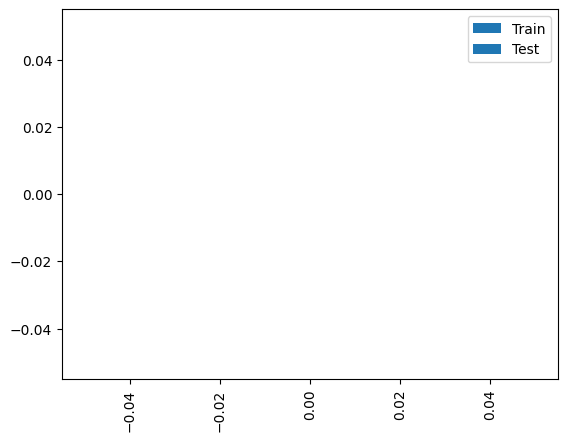

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

# Define paths
data_dir = "data/CUAD_v1/full_contract_pdf"
train_parts = ["Part_I", "Part_III"]
test_part = "Part_II"

# Function to get all PDF files in a directory and its subdirectories
def get_pdf_files(directory):
    pdf_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.pdf'):
                pdf_files.append(os.path.join(root, file))
    return pdf_files

# Function to get category from file path
def get_category(file_path):
    parts = file_path.split(os.sep)
    # The category should be the directory name before the PDF file
    for i, part in enumerate(parts):
        if part in ["part1", "part2", "part3"]:
            if i+1 < len(parts)-1:  # Ensure there's a category directory
                return parts[i+1]
    return "unknown"

# Function to get file size in KB
def get_file_size(file_path):
    return os.path.getsize(file_path) / 1024  # Convert bytes to KB

# Collect training and test files
train_files = []
for part in train_parts:
    part_path = os.path.join(data_dir, part)
    if os.path.exists(part_path):
        train_files.extend(get_pdf_files(part_path))

test_files = []
test_path = os.path.join(data_dir, test_part)
if os.path.exists(test_path):
    test_files.extend(get_pdf_files(test_path))

print(f"Found {len(train_files)} training files and {len(test_files)} test files")

# Analyze categories
train_categories = [get_category(f) for f in train_files]
test_categories = [get_category(f) for f in test_files]

train_cat_counts = pd.Series(train_categories).value_counts()
test_cat_counts = pd.Series(test_categories).value_counts()

# Merge to get all categories
all_categories = pd.concat([train_cat_counts, test_cat_counts], axis=1, sort=True).fillna(0)
all_categories.columns = ['Train', 'Test']
all_categories['Train'] = all_categories['Train'].astype(int)
all_categories['Test'] = all_categories['Test'].astype(int)

# Calculate p-values using chi-square test for each category
p_values = []
for category in all_categories.index:
    observed = [all_categories.loc[category, 'Train'], all_categories.loc[category, 'Test']]
    expected = [sum(observed) * (len(train_files) / (len(train_files) + len(test_files))),
                sum(observed) * (len(test_files) / (len(train_files) + len(test_files)))]
    
    # Only perform test if we have enough samples
    if sum(observed) > 5 and min(observed) > 0:
        _, p_value = stats.chisquare(observed, expected)
    else:
        p_value = np.nan
    
    p_values.append(p_value)

all_categories['p-value'] = p_values

# Analyze file sizes
train_sizes = [get_file_size(f) for f in train_files]
test_sizes = [get_file_size(f) for f in test_files]

# Statistical test for file sizes
size_t_stat, size_p_value = stats.ttest_ind(train_sizes, test_sizes, equal_var=False)

# Create a summary table
summary_table = pd.DataFrame({
    'Metric': ['Number of files', 'Number of categories', 'Mean file size (KB)', 'Median file size (KB)', 'File size p-value'],
    'Training': [len(train_files), len(train_cat_counts), np.mean(train_sizes), np.median(train_sizes), size_p_value],
    'Test': [len(test_files), len(test_cat_counts), np.mean(test_sizes), np.median(test_sizes), size_p_value]
})

# Display results
print("\nSummary Statistics:")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))

print("\nCategory Distribution:")
print(tabulate(all_categories, headers='keys', tablefmt='grid'))

# Visualize category distribution
plt.figure(figsize=(12, 8))
all_categories[['Train', 'Test']].plot(kind='bar')
plt.title('Category Distribution in Training and Test Sets')
plt.ylabel('Number of Documents')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize file size distribution
plt.figure(figsize=(10, 6))
plt.hist(train_sizes, alpha=0.5, label='Training', bins=30)
plt.hist(test_sizes, alpha=0.5, label='Test', bins=30)
plt.title('File Size Distribution')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print categories with significant differences (p < 0.05)
significant_categories = all_categories[all_categories['p-value'] < 0.05]
if not significant_categories.empty:
    print("\nCategories with significant differences (p < 0.05):")
    print(tabulate(significant_categories, headers='keys', tablefmt='grid'))
else:
    print("\nNo categories with significant differences found (p < 0.05)")


In [2]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Constants and assumptions
TOKENS_PER_USER = 10  # Desired tokens/sec per user
TOKENS_PER_SECOND_PER_H100 = {
    'FP16': lambda params: 1500 * (70 / params),  # Scale inversely with model size
    'INT4': lambda params: 2500 * (70 / params),  # Optimistic throughput with quantization
}

def estimate_users(throughput, target_tok_per_user):
    return int(throughput / target_tok_per_user)

def update_output(change=None):
    params = param_slider.value
    gpus = gpu_slider.value
    precision = precision_dropdown.value
    tok_per_user = token_slider.value

    total_throughput = TOKENS_PER_SECOND_PER_H100[precision](params) * gpus
    user_capacity = estimate_users(total_throughput, tok_per_user)

    output_area.value = f"### Estimated User Capacity\n" \
                        f"**Model size:** {params}B\n" \
                        f"**# GPUs (H100):** {gpus}\n" \
                        f"**Precision:** {precision}\n" \
                        f"**Throughput:** ~{int(total_throughput)} tokens/sec\n" \
                        f"**Max users @ {tok_per_user} tok/s per user:** **~{user_capacity} users**"

# UI Widgets
param_slider = widgets.IntSlider(value=70, min=1, max=175, step=1, description='Model (B):')
gpu_slider = widgets.IntSlider(value=1, min=1, max=16, step=1, description='GPUs (H100):')
precision_dropdown = widgets.Dropdown(options=['FP16', 'INT4'], value='FP16', description='Precision:')
token_slider = widgets.IntSlider(value=10, min=1, max=50, step=1, description='Tok/s per user:')
output_area = widgets.HTML()

# Set up interactivity
for widget in [param_slider, gpu_slider, precision_dropdown, token_slider]:
    widget.observe(update_output, names='value')

# Initial update
update_output()

# Display widgets
display(widgets.VBox([param_slider, gpu_slider, precision_dropdown, token_slider, output_area]))
